In [4]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import nltk # run nltk.download('punkt')
from tqdm import tqdm
import spacy
spacy_nlp_spanish = spacy.load('es_core_news_sm') # run python -m spacy download es_core_news_sm
import es_core_news_sm
spacy_nlp_spanish = es_core_news_sm.load()


2024-05-16 01:03:44.885809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 01:03:46.378017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
dataset = load_dataset("ted_talks_iwslt", language_pair=("en", "es"), year="2016") # 3068 from 2014, 3764 from 15, and 4126 from 16

In [6]:
english_portion = [d['en'] for d in dataset['train']["translation"]]
spanish_portion = [d['es'] for d in dataset['train']["translation"]]

pre data cleaning statistics


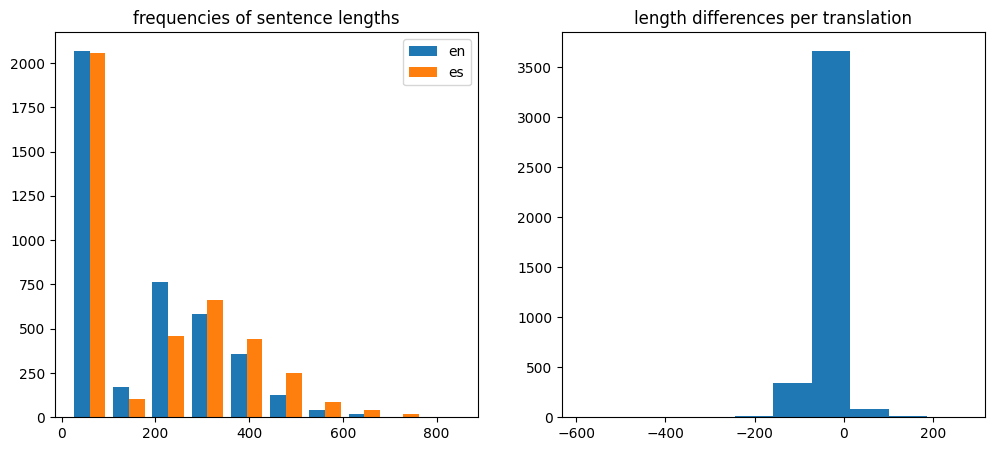

4126 4126
(274,
 376,
 102,
 'A liberal arts education is critical to forming true leaders, says '
 'university head Patrick Awuah -- because it builds decision-making skills, '
 'an ethical framework and a broad vision. Awuah himself left a career at '
 'Microsoft in the US to found a liberal arts school in Africa: Ashesi '
 'University, in his home nation of Ghana. A passionate talk about dreaming, '
 'doing and leading.',
 'Patrick Awuah argumenta que una educación artística liberal es crítica para '
 'formar verdaderos líderes.')
(-589,
 266,
 855,
 'Why is Al Gore optimistic about climate change? In this spirited talk, Gore '
 'asks three powerful questions about the man-made forces threatening to '
 "destroy our planet -- and the solutions we're designing to combat them. "
 '(Featuring Q&A with TED Curator Chris Anderson)',
 'Al Gore plantea tres preguntas sobre el cambio climático y nuestro futuro. '
 'En primer lugar: ¿Tenemos que cambiar? Cada día, la contaminación del '
 'cal

In [7]:
def plot_stats(english_portion, spanish_portion):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5) )
    # plt.rcParams['figure.dpi'] = 300
    axs[0].set_title("frequencies of sentence lengths")
    axs[0].hist(([len(s) for s in english_portion], [len(s) for s in spanish_portion]), label=["en", 'es'])
    axs[0].legend()
    axs[1].set_title("length differences per translation")
    axs[1].hist([(len(en) - len(es)) for en, es in zip(english_portion, spanish_portion)])
    plt.show()
print("pre data cleaning statistics")
plot_stats(english_portion, spanish_portion)
len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion, spanish_portion)]
print(len(spanish_portion), len(english_portion))
pprint(max(len_diffs))
pprint(min(len_diffs))


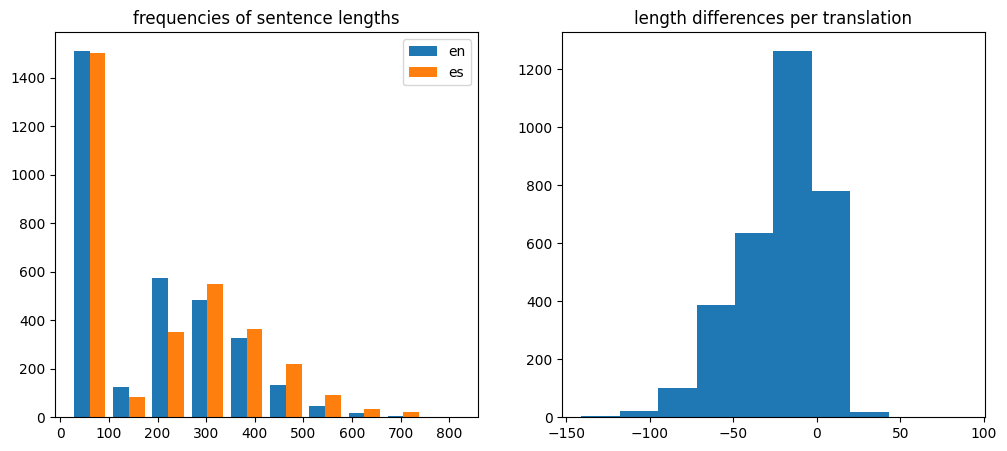

3220 3220
(89,
 514,
 425,
 "Camels are so well adapted to the desert that it's hard to imagine them "
 'living anywhere else. But what if we have them pegged all wrong? What if '
 'those big humps, feet and eyes were evolved for a different climate and a '
 "different time? In this talk, join Radiolab's Latif Nasser as he tells the "
 'surprising story of how a very tiny, very strange fossil upended the way he '
 'sees camels, and the world. This talk comes from the upcoming PBS special '
 'TED Talks: Science & Wonder, which premieres March 30th at 10 p.m. ET.',
 'Los camellos están tan bien adaptados al desierto que es difícil imaginarlos '
 'en otro lugar. Pero ¿y si los hemos catalogado mal? ¿Y si desarrollaron esas '
 'grandes jorobas, esas amplias pezuñas  y esos ojos enormes para un clima y '
 'una era diferente? En esta charla, súmate a Latif Nasser de Radiolab '
 'conforme cuenta la sorprendente historia de cómo un diminuto y singular '
 'fósil trastocó su forma de ver los cam

In [8]:
# get largest sentence length difference:
english_portion_filtered = []
spanish_portion_filtered = []
ratio = 10/8
len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion, spanish_portion)]
for len_diff in len_diffs:
    if (1/ratio < len_diff[1]/len_diff[2] < ratio) or abs(len_diff[1] - len_diff[2]) < 10:
        english_portion_filtered.append(len_diff[-2])
        spanish_portion_filtered.append(len_diff[-1])

len_diffs = [(len(en) - len(es), len(en), len(es), en, es) for en,es in zip(english_portion_filtered, spanish_portion_filtered)]
plot_stats(english_portion_filtered, spanish_portion_filtered)
print(len(spanish_portion_filtered), len(english_portion_filtered))
pprint(max(len_diffs))
pprint(min(len_diffs))

In [9]:
print(f"english dataset length, and then set length for duplicate detection:", len(english_portion), len(set(english_portion)))
print(f"spanish dataset length, and then set length for duplicate detection:", len(spanish_portion), len(set(spanish_portion)))
# for s in set(spanish_portion):
#     spanish_portion.remove(s)
# spanish_portion
print("only one repeated sentence, which is in spanish: ['La biblioteca de la imaginación humana de Jay Walker']")

english dataset length, and then set length for duplicate detection: 4126 4126
spanish dataset length, and then set length for duplicate detection: 4126 4125
only one repeated sentence, which is in spanish: ['La biblioteca de la imaginación humana de Jay Walker']


In [51]:
# creating the IBM translation model 1:
# the setup here, is we are trying to find the translation pairs. 
# We first off want to maximize the likelihood of translation from spanish to english under the model of p(e | s) ~ p(e) * p(s | e), 
# as our spanish sentence doesn't need to consider it's likelihood.
# 
# 
# need to have parameters for translation first, and then need to have parameters for 
# spanish_voc = 

spacy_word_tokenize = lambda s: [w.text for w in spacy_nlp_spanish(s)]
english_tokens = [nltk.word_tokenize(s) for s in english_portion_filtered]
spanish_tokens = [spacy_word_tokenize(s) for s in spanish_portion_filtered]
# nltk.word_tokenize("Economic growth is the defining challenge of our time; without it, political")

In [52]:
from collections import Counter

In [53]:
def create_voc(tokens, new_tokens=[]):
    threshold = 10
    tokens_above_threshold = sorted(list(filter(lambda x: x[1] > threshold, Counter(w for s in tokens for w in s).items())))
    tokens_above_threshold = new_tokens + [w for w, _ in tokens_above_threshold]
    
    voc2indx = {w: i for i, w in enumerate(tokens_above_threshold)}

    indx2voc = list(voc2indx.keys())
    return voc2indx, indx2voc

voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens, new_tokens=["<NULL>", "<UNK>"])

In [54]:
def create_en_and_es_dataset(english_tokenized, spanish_tokenized, voc2indx_english, voc2indx_spanish):
    english_tokens_with_unk = [[(w if w in voc2indx_english else "<UNK>") for w in s]+["<NULL>"] for s in english_tokenized]
    spanish_tokens_with_unk = [[(w if w in voc2indx_spanish else "<UNK>") for w in s] for s in spanish_tokenized]
    return english_tokens_with_unk, spanish_tokens_with_unk
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens, spanish_tokens, voc2indx_english, voc2indx_spanish)

In [55]:
def create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk):
    data = list(zip(english_tokens_with_unk, spanish_tokens_with_unk))
    return data
def create_empty_model(data):
    paired_tokens = []
    for english_sentence, spanish_sentence in data:
        for e in english_sentence:
            for s in spanish_sentence:
                paired_tokens.append((s,e))
    model_p = {k: 0 for k in set(paired_tokens)}
    return model_p
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
# model_p = create_empty_model(data)

In [56]:
# the p(s | e), and then some prior for the location of the word.
# the thing we want to determine is p(a | f, e)
# E and M between finding the best allignment for the probability model on the text alignment, and the best alignment for the model.
# p(a | f, e) * p(f | e) = p(f | e, a) * p(a | e), where p(f | e) = sum_{a \in all alignments}{p(f | a, e) * p(a | e)}
# under model 1, the alignment model p(a | e) is simply the uniform over the sentence: 1 / (l + 1)
# we really want to decompose each decision to be per word, so the following model is what we use:
# the alignment is the latent variable, where you have one latent for every word in every sentence representing where it is aligned to in the english sentence.
# p(a_j | f_j, e) * p(f_j | e) = p(f_j | a_j, e) * p(a_j | e), where now p(f_j | e) = sum_{i in l + 1}{p(f | a_j=i, e) * p(a_j = i | e)}

# with p(a_j = i | e) being 1/ (l+1) still for model 1
# I see that I need to change the p(f | e), on a per word basis, but how do I change the alignments? Do I pick the most probable ones? 
# or just pick the asignments on a simplex ie softly?

In [57]:
# first randomly init params for a new model
def inplace_init_model_params(model):
    num_spanish_words = len(set(k[0] for k in model))
    for key in model:
        model[key] = 1 / num_spanish_words
# inplace_init_model_params(model_p)


In [58]:
# E step: creating counts for which it is easy to do the maximization step for.
def perform_E_step(model, data):
    counts_for_s_j_e_i_pairs = {k: 0 for k in model}
    for e, s in data:
        for s_j in s:
            p_s_j_given_e_without_q_a = sum(model[(s_j, e_k)] for e_k in e)
            for e_i in e:
                counts_for_s_j_e_i_pairs[(s_j, e_i)] += model[(s_j, e_i)] / p_s_j_given_e_without_q_a# the count of the spanish and english copairs.
                # They occur with eachother depending on the probability of alignment p(a_j = i | f_j, e)
                # can you use the entire sentence of s's to evaluate the alignment? This would make the bayes model more complex:
                # p(a_j = i | f, e) p(f | e) <- you need this model = p(f | a_j = i, e) <- this model doesn't make sense, so you need to basically combine all your alignments.
                # then you have p(a | f, e), and you have a full alignment model, and no easy way to optimize???
    return counts_for_s_j_e_i_pairs
# counts_for_s_j_e_i_pairs = perform_E_step(model_p, data)

In [59]:
# M step:
def perform_M_step(counts_for_s_j_e_i_pairs):
    counts_for_e_i = {u: 0 for u in set(k[1] for k in counts_for_s_j_e_i_pairs)}
    for pair, value in counts_for_s_j_e_i_pairs.items():
        counts_for_e_i[pair[1]] += value

    new_model = {k: v / counts_for_e_i[k[1]]  for k, v in counts_for_s_j_e_i_pairs.items()}
    return new_model

# new_model_p = perform_M_step(counts_for_s_j_e_i_pairs)

In [60]:
# evaluate the log_likelihood
def get_likelihood(model, data):
    likelihood = 0 # ignoring the model for e, just minimize your probability under your model for the 
    for e, s in data:
        # probability of an alignment p(f | e) = Prod_j{ sum_{alignments}{ p(f_j|a_j, e) * p(a_j | e)} }
        for s_j in s:
            likelihood += np.log(1/len(e)) + np.log(sum(model[(s_j, e_i)] for e_i in e))
    return likelihood
# get_likelihood(model_p, data), get_likelihood(new_model_p, data)

In [61]:
# do this in a loop:
def optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood):
    num_epochs = 10
    last_likelihood = 0
    for epoch in range(num_epochs):
        counts_for_s_j_e_i_pairs = perform_E_step(model_p, data)
        new_model_p = perform_M_step(counts_for_s_j_e_i_pairs)
        new_likelihood = get_likelihood(new_model_p, data)
        print(f"epoch {epoch=}, with likelihood=", new_likelihood)
        if last_likelihood == new_likelihood:
            break
        last_likelihood = new_likelihood
        model_p = new_model_p
    return model_p
# model_p = optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood)


In [62]:
# english to english to visualize ambiguities in the model, specifically ones which can easily be solved by a more accurate position prior.

# # voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens, new_tokens=["<NULL>"])
# voc2indx_english, indx2voc_english = create_voc(english_tokens, new_tokens=["<NULL>", "<UNK>"])
# voc2indx_english0, indx2voc_english0 = create_voc(english_tokens, new_tokens=["<NULL>"])
# english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens, english_tokens, voc2indx_english, voc2indx_english0)
# data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
# model_p = create_empty_model(data)
# inplace_init_model_params(model_p)
# print(f"starting likelihood: {(get_likelihood(model_p, data))}")
# model_p = optimize_model(model_p, data, perform_E_step, perform_M_step, get_likelihood)



In [63]:
# code cell for old implementation of the IMB model 2, where I used 
# P(i | j, m, l) as the count frequency of the number of occurances of i for position j when the length of the sequences were m, and l. 
# I would remove infrequent length pairs. Now I will be using a fraction based on relative position int(abs(j - i *(m / l))), 
# where I now don't need to condition on the length m of the french sentence, but I should condition on l, because I need to normalize 
# the choice of i over the possible i I could have chosen. p(i | j, l) = count(int(abs(j - i *(m / l)))) / sum_i^l{count(int(abs(j - i *(m / l))))}

# len_sentences = list(zip([len(e) for e in english_tokens], [len(s) for s in spanish_tokens]))
# english_tokens_filtered = []
# spanish_tokens_filtered = []
# count_english_lens = Counter([len(e) for e in english_tokens])
# count_spanish_lens = Counter([len(s) for s in spanish_tokens])
# threshold = 4
# for i, (l, m) in enumerate(len_sentences):
#     if count_english_lens[l] >= threshold and count_spanish_lens[m] >= threshold: this code seems wrong TODO: fix if I ever uncomment.
#         english_tokens_filtered.append(english_tokens[i])
#         spanish_tokens_filtered.append(spanish_tokens[i])
english_tokens_filtered, spanish_tokens_filtered = english_tokens, spanish_tokens
print(len(english_tokens_filtered), len(spanish_tokens_filtered))

3220 3220


In [64]:
def create_empty_model_2(data):
    # need to have model parameters in the form of p(f_j | e_i) pairs, and in the form of positional conditioning, with q(i | j, m, l)
    pairs = []
    position_pairs = []
    for e, s in data:
        l, m = len(e), len(s)
        for i, e_i in enumerate(e):
            for j, s_j in enumerate(s):
                pairs.append((s_j, e_i))
                position_pairs.append((int(abs(i-j*l/m)), l))
    model = {p:0 for p in list(set(pairs)) + list(set(position_pairs))}
    return model
# model_p = create_empty_model_2(data)

In [65]:
print([min((len(sent),sent) for sent in sentences) for sentences in zip(*data)])
# TODO: fix the problem of sentences with too many unks, by filtering them out? And then might need to recreate the dictionary, and repeat the process of filtering out unk words which have few occurances and then filtering out sentences yet again.

[(6, ['<UNK>', ':', 'The', '<UNK>', 'me', '<NULL>']), (4, ['Jonathan', '<UNK>', '<UNK>', 'historias'])]


In [103]:
def inplace_init_model_2_params(model):
    # need to init the model parameters to a reasonable baseline, try uniform again. with p(f_j | e_i) uniform over the words f_j in the model for all the conditionals.
    num_s = len(set(p[0] for p in model if len(p) == 2 and isinstance(p[0], str))) 
    # want to ignore the len 3 which represents positional, for that I will do uniform over the l avaialble position alignments
    for key in model.keys():
        if isinstance(key[0], str):
            model[key] = 1 / num_s
        elif isinstance(key[0], int):
            model[key] = 1 / key[-1]
        else:
            raise Exception(f"Should only have str or int dict's keys, but got key: {key}")
# inplace_init_model_2_params(model_p)

In [104]:
print(f"the number of unique sentence lengths in each language",[len(set((len(sent)) for sent in sentences)) for sentences in zip(*data)])

the number of unique sentence lengths in each language [123, 132]


In [105]:
print("the number of sentneces of a particular length")
# [np.unique(list(len(sent) for sent in sentences),return_counts=True) for sentences in zip(*data)]

the number of sentneces of a particular length


In [106]:
def get_likelihood_model_2(model, data):
    # p(f | e)  = p( |f|  | e) * Prod_j  Sum_i(p(f_j | a_j, e) * p(a_j = i | j, |f|, |e|, e))
    # p( |f|  | e)  = 1 / 96 for now, 
    # TODO: fix to be correct probabilty. Could just be figured out by the data. 
    # I will just set a uniform over the true number of unique sentence lengths.
    likelihood = 0
    for e, s in data:
        l, m = len(e), len(s)
        likelihood += np.log(1 / 96)
        for j, s_j in enumerate(s):
            likelihood += np.log(
                sum(model[(s_j, e_i)] * model[(int(abs(i-j*l/m)), l)] for i, e_i in enumerate(e))
            )
    return likelihood
# get_likelihood_model_2(model_p, data)

In [107]:
def perform_E_step_model_2(model, data):
    counts = {key: 0 for key in model}
    counts.update({(k,): 0 for k in range(max(len(en) for es, en in data))})
    # get the expected counts when your model would be sampled under your latent parameters. This is the alignment probabilities that your model has.
    for e, s in data:
        l, m = len(e), len(s)
        for j, s_j in enumerate(s):
            p_s_j_given_j_and_e = sum(model[(s_j, e_k)] * model[(int(abs(k-j*l/m)), l)] for k, e_k in enumerate(e))
            for i, e_i in enumerate(e):
                p_s_j_and_a_j_given_and_j_and_e = model[(s_j, e_i)] * model[(int(abs(i-j*l/m)), l)]
                p_a_j_given_s_j_and_j_and_e = p_s_j_and_a_j_given_and_j_and_e / p_s_j_given_j_and_e
                counts[(int(abs(i-j*l/m)),)] += p_a_j_given_s_j_and_j_and_e
                counts[(s_j, e_i)] += p_a_j_given_s_j_and_j_and_e # add the event that s_j aligns with e_i for this sentence: 
                # p(a_j = i | f_j, e)  * p(|f| | e) sum_k(p(f_j | a_j=k, e) * p(a_j=k | i, |f|, |e|, e)) = p(f_j | a_j = i, e) * p(a_j = i | i, |f|, |e|, e) * p(|f| | e)
                # p(a_j = i | f_j, e) =  p(f_j | a_j = i, e) * p(a_j = i | i, |f|, |e|, e) / sum_k(p(f_j | a_j=k, e) * p(a_j=k | i, |f|, |e|, e))

    return counts
# counts = perform_E_step_model_2(model_p, data)

In [108]:
def perform_M_step_model_2(counts):
    new_model_p = dict()
    normalizing_counts = Counter()
    lengeths = set()
    for key, count in counts.items():
        if isinstance(key[0], str):
            normalizing_counts[key[1:]] += count
        elif len(key) == 2:
            lengeths.add(key[1])
    # need to get the p(i | j, l) = counts(int(abs(i - j*l/m))) / sum_k_l(counts(int(abs(k - j*l/m))))
    for length in lengeths:
        total_count_of_relatives = sum(counts[(k,)] for k in range(length))
        for i in range(length):
            new_model_p[(i, length)] = counts[(i,)] / total_count_of_relatives
    for key, count in counts.items():
        if isinstance(key[0], str):
            new_model_p[key] = count / normalizing_counts[key[1:]]
    return new_model_p
# new_model_p = perform_M_step_model_2(counts)

In [109]:
# voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens_filtered, new_tokens=["<NULL>"])
# voc2indx_english, indx2voc_english = create_voc(english_tokens_filtered, new_tokens=["<NULL>", "<UNK>"])
# # voc2indx_english0, indx2voc_english0 = create_voc(english_tokens_filtered, new_tokens=["<NULL>"])
# english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens_filtered, spanish_tokens_filtered, voc2indx_english, indx2voc_spanish)
# data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
# model_p = create_empty_model_2(data)
# inplace_init_model_2_params(model_p)
# print(f"starting likelihood: {(get_likelihood_model_2(model_p, data))}")
# model_p = optimize_model(model_p, data, perform_E_step_model_2, perform_M_step_model_2, get_likelihood_model_2)

In [110]:
voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens_filtered, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens_filtered, new_tokens=["<NULL>", "<UNK>"])
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens_filtered, spanish_tokens_filtered, voc2indx_english, indx2voc_spanish)
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)


In [111]:
# HMM model now: 
def create_empty_model_HMM(data):
    # need to have model parameters in the form of p(f_j | e_i) pairs, and in the form of positional conditioning, 
    # with q(a_j | a_{j-1}, l) = count(int(abs(a_j - a_{j-1}))) / sum_k^l(int(abs(k - a_{j-1})))
    pairs = []
    position_pairs = []
    for e, s in data:
        l, m = len(e), len(s)
        for i, e_i in enumerate(e):
            position_pairs.extend(zip([i]*(l+1), range(-1, l), [l] * (l+1))) # i, prior_i(includes start=-1), length
            for j, s_j in enumerate(s):
                pairs.append((s_j, e_i))
    model = {p:0 for p in list(set(pairs)) + list(set(position_pairs))}
    return model
model_p = create_empty_model_HMM(data)


In [112]:
def inplace_init_model_HMM_params(model):
    # just normalize over the number of options available for each parameter:
    num_s = len(set(p[0] for p in model if len(p) == 2 and isinstance(p[0], str))) 
    for key in model:
        if len(key) == 2:
            if isinstance(key[0], str):
                model[key] = 1 / num_s
        else:
            # (i, prior_i, l)
            model[key] = 1 / key[-1]
inplace_init_model_HMM_params(model_p)


In [113]:
def forward_alg(en, es, model):
    # this needs the model to have a prior for the probability of starting at each position.
    # for this assumption, I call z_0 =  -1, and then use the Q model to give me the probability of transitioning form -1 to 0, 1, 2, ... l. 
    # This biases the probability to start near the beginning if the Q model doesn't do a lot of skipping around.
    # I need to deal in log probs else it is unstable. ->> nevermind, I don't think I can really, because I need to exp the values to get true probabilities for the recursive case any way. The sum from the latents prevents moving the log in, and covering the prob of x, z.
    m, l = len(es), len(en)
    prob_x_leq_k_and_z_k = [[None] * m for _ in range(l)]
    for i in range(l):
        prob_x_leq_k_and_z_k[i][0] = model[(i, -1, l)] * model[(es[0], en[i])]
    for j in range(1, m):
        for i in range(l):
            prob_x_leq_k_and_z_k[i][j] = model[(es[j], en[i])] * sum(model[(i, k, l)] * prob_x_leq_k_and_z_k[k][j-1] for k in range(l))
    # the forward's recurrence tries to capture p(z_j = i, x_{1:j}) = p(x_j | z_j = i) * sum_k(p(z_j = i | z_{j-1} = k) * p(z_{j-1} = k, x_{1:j-1}))

    return prob_x_leq_k_and_z_k

# forward_alg(
#     ['<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about'], 
#     ['La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre'],
#     model_p
# );

In [114]:
def backward_alg(en, es, model):
    # here we want to get p(x_{j+1:l} | z_j = i) to be able to combine with fwd to get the probability of a sequence given some choice of the latent.
    # p(x_{j+1:l} | z_j = i) = sum_k^l( p(x_{j+1} | z_{j+1} = k) * p(z_{j+1} = k | z_j = i) p(x_{j+2:l} | z_{j+1} = k))
    m, l = len(es), len(en)
    prob_x_gt_k_given_z_k = [[None] * m for _ in range(l)]
    # init the beginning, but to what, just see how it is used in the recurrence:
    # p(x_{l:l} | z_{l-1} = i) = sum_k^l( p(z_l = k | z_{l-1} = i) * p(x_l | z_l = k) ) # hence if we want our recurrence to be defined here, just set the probabilities of the l'th column to be all 1s.
    for i in range(l):
        prob_x_gt_k_given_z_k[i][-1] = 1
    
    for j in reversed(list(range(0, m-1))):
        for i in range(l):
            prob_x_gt_k_given_z_k[i][j] = sum(model[(k, i, l)] * model[(es[j+1], en[k])] * prob_x_gt_k_given_z_k[k][j+1] for k in range(l))
    
    return prob_x_gt_k_given_z_k
# backward_alg(
#     ['<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about'], 
#     ['La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre'],
#     model_p
# );

In [115]:
# en = ['<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about']
# es = ['La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre']
# fwd = forward_alg(
#     en,
#     es,
#     model_p
# )
# bkwd = backward_alg(
#     en,
#     es,
#     model_p
# )
# print("complete probability from the forward algorithm", sum(fwd[i][-1] for i in range(len(en))))
# print("complete probability from the backward algorithm", sum(bkwd[i][0] * model_p[(i, -1, len(en))] * model_p[(es[0], en[i])] for i in range(len(en))))

In [116]:
def forward_backward_alg(en, es, model):
    # produce the p(a_j, f) values in a matrix just as fwd and bkwd produce by combining the latter two.
    fwd = forward_alg(en, es, model)
    bkwd = backward_alg(en, es, model)
    m, l = len(es), len(en)
    fwd_bkwd = [[None] * m for _ in range(l)]
    # each entry is p(a_j, f), where fwd is p(a_j, f_{1:j}), and bkwd is p(f_{j+1:l} | a_j) in each entry respectively
    for i in range(l):
        for j in range(m):
            fwd_bkwd[i][j] = fwd[i][j] * bkwd[i][j]
    return fwd_bkwd
forward_backward_alg(
    # ['A', 'million', '<UNK>', '<UNK>', 'in', '<UNK>', 'this', 'year', ',', 'says', '<UNK>', '<UNK>', ',', 'and', '``', 'our', '<UNK>', ',', '<UNK>', ',', 'has', 'been', '<UNK>', '.', "''", '<UNK>', 'studies', '<UNK>', '<UNK>', ',', 'the', '<UNK>', '<UNK>', 'for', '<UNK>', 'between', 'the', '<UNK>', ',', 'urban', 'poverty', 'and', 'dangerous', '<UNK>', '<UNK>', 'to', '<UNK>', '.', 'In', 'this', '<UNK>', 'talk', ',', 'he', 'offers', 'four', 'ways', 'to', 'change', 'the', 'way', 'we', 'treat', '<UNK>', ',', 'so', 'they', 'can', 'make', 'an', '<UNK>', '<UNK>', 'to', 'their', 'new', 'homes', '.', '``', 'There', "'s", 'nothing', '<UNK>', 'about', '<UNK>', 'being', 'a', 'cost', ',', "''", '<UNK>', 'says', '.', '``', 'They', "'re", 'human', '<UNK>', 'with', 'skills', ',', '<UNK>', ',', '<UNK>', ',', 'with', 'the', 'ability', 'to', 'make', '<UNK>', '--', 'if', 'we', 'let', 'them', '.', "''", '<NULL>'],
    # ['Un', '<UNK>', 'de', 'refugiados', '<UNK>', 'a', '<UNK>', 'este', 'año', ',', 'dice', '<UNK>', '<UNK>', ',', 'y', '"', 'nuestra', 'respuesta', ',', '<UNK>', ',', 'ha', 'sido', '<UNK>', '”', '.', '<UNK>', 'estudia', 'la', '<UNK>', '<UNK>', ',', 'la', '<UNK>', '<UNK>', 'para', 'las', '<UNK>', 'entre', '<UNK>', 'de', 'refugiados', ',', 'pobreza', '<UNK>', 'o', '<UNK>', '<UNK>', '<UNK>', 'en', 'busca', 'de', 'seguridad', '.', 'En', 'esta', 'charla', '<UNK>', ',', 'ofrece', 'cuatro', 'maneras', 'de', 'cambiar', 'la', 'forma', 'de', 'tratar', 'a', 'los', 'refugiados', ',', 'para', 'que', 'puedan', '<UNK>', 'de', 'forma', '<UNK>', 'a', 'sus', 'nuevos', '<UNK>', '.', '"', 'No', 'es', '<UNK>', 'que', 'los', 'refugiados', 'sean', 'un', 'costo', '"', ',', 'dice', '<UNK>', '.', '"', '<UNK>', 'seres', 'humanos', 'con', 'habilidades', ',', '<UNK>', ',', '<UNK>', 'que', 'pueden', '<UNK>', ',', 'si', 'los', '<UNK>', '"', '.'],
    ['<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about', '<UNK>', '<UNK>', "'s", 'photography', 'challenges', 'how', 'we', 'think', 'about'], 
    ['La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre', 'La', 'fotografía', 'de', '<UNK>', '<UNK>', '<UNK>', 'nuestra', 'forma', 'de', 'pensar', 'sobre'],
    model_p
);


In [117]:
def get_likelihood_model_HMM(model, dataloader):
    likelihood = 0
    # we want to get log(p(f | e))
    num_zeros = 0
    iterator = tqdm(dataloader)
    iterator.set_postfix_str(s=f"{num_zeros=}")
    for en, es in iterator:
        # getting the probability of the data with the model involves: for each f, e sentence
        # p(f | e) = p(f | e), which is easy to get from the forward process, as we use our markov model. 
        # Otherwise we might want to do the sum over the sum of all possible alignments.
        prob_x_leq_j_and_z_j = forward_alg(en, es, model)
        prob_x_given_e = sum(prob_x_leq_j_and_z_j[i][-1] for i in range(len(en)))
        if prob_x_given_e != 0.:
            likelihood += np.log(prob_x_given_e)
        else:
            num_zeros += 1
            iterator.set_postfix_str(s=f"{num_zeros=}")
            # print("zero probability translation event:", len(en), len(es), en, es)
    return likelihood
# get_likelihood_model_HMM(model_p, data) # 811415.0956993197


In [123]:
def perform_E_step_model_HMM(model, dataloader):
    # to get the E step, you have to essentially find the Q(a_j | a_{j-1}, f_j, e), which comes out of model. for this you apply bayes, and use your existing model?
    # Q(a_j | a_{j-1}, f_j, e) = Q(a_j | a_{j-1}, e) * p(f_j | e_{a_j}) / sum_k^l(Q(a_j = k | a_{j-1}, e) * p(f_j | e_k))
    keys = [key for key in model.keys()]
    longest_english_sentence = max(len(en) for en, es in dataloader)

    keys.extend([(i,) for i in range(longest_english_sentence)])
    keys.extend((i,-1) for i in range(longest_english_sentence))
    counts = {k: 0 for k in keys}

    iterator = tqdm(dataloader)
    num_skips = 0
    iterator.set_postfix_str(s=f"{num_skips=}")

    for en, es in iterator:
        m, l = len(es), len(en)
        # print(en, es)
        prob_f_leq_j_and_a_j_given_e = forward_alg(en, es, model) # 2 * m * l * l operation
        prob_f_gt_j_given_a_j_and_e = backward_alg(en, es, model)
        prob_f_and_a_j_given_e = [[f_i * b_i for f_i,b_i in zip(f, b)] for f,b in zip(prob_f_leq_j_and_a_j_given_e, prob_f_gt_j_given_a_j_and_e)]
        # arr = np.array(prob_f_and_a_j_given_e)
        # from pprint import pprint
        # print("+"*20)
        # print('prob_f_and_a_j_given_e')
        # pprint(np.array(prob_f_and_a_j_given_e).sum(axis=0))
        # print("prob_f_leq_j_and_a_j_given_e")
        # pprint(np.array(prob_f_leq_j_and_a_j_given_e).sum(axis=0))
        # print("prob_f_gt_j_given_a_j_and_e")
        # pprint(prob_f_gt_j_given_a_j_and_e)
        # print(sum(prob_f_gt_j_given_a_j_and_e[i][0] * model_p[(i, -1, len(en))] * model_p[(es[0], en[i])] for i in range(len(en))))
        # pprint(model)
        # # plt.imshow(arr)
        # # plt.show()
        # print("m, l",m, l)
        # print(prob_f_and_a_j_given_e)
        q_f_given_e = sum(prob_f_and_a_j_given_e[k][-1] for k in range(l)) 
        # print(f"{q_f_given_e = }, ")
        # could be determined on one higher level up. Not sure if this will be different because of some numerical issues? TODO: check if there are issues with numerical stability?
        if q_f_given_e == 0.:
            num_skips += 1
            iterator.set_postfix_str(s=f"{num_skips=}")
            continue
        for j, s in enumerate(es):
            for i, e in enumerate(en):
                # update the counts of the f_j, e_i pairs based on the Q(a_j| f, e)
                q_a_j_given_f_and_e = prob_f_and_a_j_given_e[i][j] / q_f_given_e
                if j == 0:
                    counts[(i,-1)] += q_a_j_given_f_and_e
                counts[(s,e)] += q_a_j_given_f_and_e
                for prior_i in range(l):
                    # update the counts of the transition probabilities for relative locations on the markov chain with
                    # Q(a_j, a_{j-1} | f, e), and compute this with bayes on Q(a_j, a_{j-1}, f | e) / Q(f | e)
                    # Q(a_j, a_{j-1}, f | e) = p(f_{1:j-1},a_{j-1}|e) * Q(a_j|a_{j-1},e) * p(f_j|a_j,e) * p(f_{j+1:m}|a_j,e)
                    q_a_j_and_a_jm1_and_f_given_e = prob_f_leq_j_and_a_j_given_e[prior_i][j-1] * model[(i, prior_i, l)] * model[(s,e)] * prob_f_gt_j_given_a_j_and_e[i][j]
                    q_a_j_and_a_jm1_given_f_and_e = q_a_j_and_a_jm1_and_f_given_e / q_f_given_e
                    counts[(int(abs(i - prior_i)),)] += q_a_j_and_a_jm1_given_f_and_e
    
    return counts
# counts = perform_E_step_model_HMM(model_p, data)

In [124]:
def perform_M_step_model_HMM(counts):
    # normalize the counts
    # we have two counts, counts for relative locations, and counts for the alignment of f_j to e_i, getting the latter is easy:
    new_model = {k: 0. for k in counts if len(k) == 2 and k[-1] != -1}
    total_e_i_counts = {k: 0. for k in set(key[1] for key in counts if isinstance(key[0], str))}
    lengths = set(key[-1] for key in counts if not isinstance(key[0], str) and len(key) == 3)
    for key, count in counts.items():
        if isinstance(key[0], str):
            total_e_i_counts[key[1]] += count
    # print(lengths)
    for length in lengths:
        # len(k) == 2 and k[-1] != -1
        normalizing_prob_i_given_prior_i = sum(counts[(k,-1)] for k in range(length))
        for i in range(length):
            new_model[(i, -1, length)] = counts[(i,-1)] / normalizing_prob_i_given_prior_i
        for prior_i in range(length):
            normalizing_prob_i_given_prior_i = sum(counts[(abs(int(k-prior_i)),)] for k in range(length))
            for i in range(length):
                new_model[(i, prior_i, length)] = counts[(abs(int(i-prior_i)),)] / normalizing_prob_i_given_prior_i
    new_model.update({key: ((count/ total_e_i_counts[key[1]]) if total_e_i_counts[key[1]] != 0. else 0.) for key, count in counts.items() if isinstance(key[0], str)})
    return new_model
# new_model_p = perform_M_step_model_HMM(counts)

In [125]:
# test to ensure everything is a probability: per en word everything should sum to 1.
def check_model(model):
    en_words = {k[1]: 0. for k in model if isinstance(k[0], str)}
    # model
    for k in model:
        if isinstance(k[0], str):
            en_words[k[1]] += model[k]
    for v in en_words.values():
        if abs(v - 1) > 0.000001:
            print("DIFFERENT THAN 1")
    
    
    # check that all probabilities over the start tokens sum to one
    conditioning = {key[1:]: 0. for key in model if not isinstance(key[0], str) and len(key) == 3}
    for k in model:
        if not isinstance(k[0], str) and len(k) == 3:
            conditioning[k[1:]] += model[k]
    for v in conditioning.values():
        if abs(v - 1) > 0.000001:
            print("DIFFERENT THAN 1")
    return en_words, conditioning
# check_model(new_model_p)

In [126]:
voc2indx_spanish, indx2voc_spanish = create_voc(spanish_tokens_filtered, new_tokens=["<NULL>"])
voc2indx_english, indx2voc_english = create_voc(english_tokens_filtered, new_tokens=["<NULL>", "<UNK>"])
# voc2indx_english0, indx2voc_english0 = create_voc(english_tokens_filtered, new_tokens=["<NULL>"])
english_tokens_with_unk, spanish_tokens_with_unk = create_en_and_es_dataset(english_tokens_filtered, spanish_tokens_filtered, voc2indx_english, indx2voc_spanish)
data = create_data_iterator(english_tokens_with_unk, spanish_tokens_with_unk)
data_temp = [(list("123"),list("123"))]
data = data[-400:]
model_p = create_empty_model_HMM(data)
inplace_init_model_HMM_params(model_p)
print(f"starting likelihood: {(get_likelihood_model_HMM(model_p, data))}")
model_p = optimize_model(model_p, data, perform_E_step_model_HMM, perform_M_step_model_HMM, get_likelihood_model_HMM)

100%|██████████| 400/400 [00:03<00:00, 119.07it/s, num_zeros=0]


starting likelihood: -72873.84148559974


100%|██████████| 400/400 [00:03<00:00, 131.90it/s, num_zeros=0]


epoch epoch=0, with likelihood= -37943.32355983889


100%|██████████| 400/400 [00:03<00:00, 130.69it/s, num_zeros=0]


epoch epoch=1, with likelihood= -34360.313312665414


100%|██████████| 400/400 [00:03<00:00, 130.41it/s, num_zeros=0]


epoch epoch=2, with likelihood= -31691.09124046462


100%|██████████| 400/400 [00:03<00:00, 130.72it/s, num_zeros=0]


epoch epoch=3, with likelihood= -29403.663779780083


100%|██████████| 400/400 [00:03<00:00, 130.28it/s, num_zeros=0]


epoch epoch=4, with likelihood= -27486.225789458473


100%|██████████| 400/400 [00:03<00:00, 130.65it/s, num_zeros=0]


epoch epoch=5, with likelihood= -26055.80115587738


100%|██████████| 400/400 [00:03<00:00, 129.42it/s, num_zeros=0]


epoch epoch=6, with likelihood= -25162.7304383914


100%|██████████| 400/400 [00:03<00:00, 129.32it/s, num_zeros=0]


epoch epoch=7, with likelihood= -24625.956849302253


100%|██████████| 400/400 [00:03<00:00, 127.16it/s, num_zeros=0]


epoch epoch=8, with likelihood= -24301.84487417575


100%|██████████| 400/400 [00:03<00:00, 130.56it/s, num_zeros=0]

epoch epoch=9, with likelihood= -24099.50856766736


In [ ]:
# english 2 english
# IBM 1
# under model 1: starting likelihood: -810764.5064618264
# epoch epoch=0, with likelihood= -482233.3330351652
# epoch epoch=1, with likelihood= -404384.8926266134
# epoch epoch=2, with likelihood= -365642.55940508656
# epoch epoch=3, with likelihood= -353090.00473416905
# epoch epoch=4, with likelihood= -347941.1196984507
# epoch epoch=5, with likelihood= -345321.0988599758
# epoch epoch=6, with likelihood= -343773.93500375556
# epoch epoch=7, with likelihood= -342761.83320770366
# epoch epoch=8, with likelihood= -342052.8103791087
# epoch epoch=9, with likelihood= -341532.8717563879
# IMB 2
# under model: starting likelihood: -773022.7161972101
# epoch epoch=0, with likelihood= -462290.9706145603
# epoch epoch=1, with likelihood= -289209.87861828593
# epoch epoch=2, with likelihood= -102219.52982528713
# epoch epoch=3, with likelihood= -28093.816094111553
# epoch epoch=4, with likelihood= -16030.130320738148
# epoch epoch=5, with likelihood= -14790.177472912908
# epoch epoch=6, with likelihood= -14559.907509435521
# epoch epoch=7, with likelihood= -14486.988450472141
# epoch epoch=8, with likelihood= -14455.438355445734
# epoch epoch=9, with likelihood= -14438.807682623446

In [130]:
# english 2 spanish:
# IBM 1
# epoch epoch=0, with likelihood= -509568.03483459953
# epoch epoch=1, with likelihood= -469732.95852562995
# epoch epoch=2, with likelihood= -447415.1996407567
# epoch epoch=3, with likelihood= -437916.6359590436
# epoch epoch=4, with likelihood= -433379.4022666768
# epoch epoch=5, with likelihood= -430847.66968394944
# epoch epoch=6, with likelihood= -429248.65894737176
# epoch epoch=7, with likelihood= -428150.48669710866
# epoch epoch=8, with likelihood= -427355.4868860529
# epoch epoch=9, with likelihood= -426759.2274307297

# IBM 2
# starting likelihood: -831979.5985877505
# epoch epoch=0, with likelihood= -490539.3986787033
# epoch epoch=1, with likelihood= -404575.6224341665
# epoch epoch=2, with likelihood= -315761.0703978876
# epoch epoch=3, with likelihood= -259147.3530734786
# epoch epoch=4, with likelihood= -213536.93665181322
# epoch epoch=5, with likelihood= -182067.16616245802
# epoch epoch=6, with likelihood= -166586.5897785949
# epoch epoch=7, with likelihood= -159675.19139906843
# epoch epoch=8, with likelihood= -156303.03081011726
# epoch epoch=9, with likelihood= -154438.79322711463

# IBM 2 with relative positional probability of i given j and l.
# starting likelihood: -901559.5730522622
# epoch epoch=0, with likelihood= -479048.1581928681
# epoch epoch=1, with likelihood= -390634.5746851009
# epoch epoch=2, with likelihood= -332356.07621157
# epoch epoch=3, with likelihood= -302499.39029506076
# epoch epoch=4, with likelihood= -288583.0036782867
# epoch epoch=5, with likelihood= -282639.83623764076
# epoch epoch=6, with likelihood= -279917.07737428404
# epoch epoch=7, with likelihood= -278476.91926890746
# epoch epoch=8, with likelihood= -277619.6784727036
# epoch epoch=9, with likelihood= -277064.08850122296


In [131]:
def get_alignment_matrix(model, en, es):
    p_a_j_given_f_j_e = np.zeros((len(en), len(es)), dtype=np.float32)
    for j, s_j in enumerate(es):
        normalizing_spanish_prob_f_j_given_e_without_q = sum(model[(s_j, e_k)] for e_k in en)
        for i, e_i in enumerate(en):
            p_a_j_given_f_j_e[i,j] = round(model[(s_j, e_i)] / normalizing_spanish_prob_f_j_given_e_without_q, 2)
    return p_a_j_given_f_j_e

def visualize_sentence_alignments(p_a_j_given_f_j_e, en, es):
    fig, ax = plt.subplots(figsize = (len(es) * 0.5, len(en) * 0.5))
    im = ax.imshow(p_a_j_given_f_j_e)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(es)), labels=es)
    ax.set_yticks(np.arange(len(en)), labels=en)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(en)):
        for j in range(len(es)):
            text = ax.text(j, i, p_a_j_given_f_j_e[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("es to en alignment probs (p(a_j | f_j, e))") 
    # does it make sense to use these probabilities, what do I want to know?
    # I do want to know about how likely some word is to align with this word, 
    # but I think this probability should sum to one over the english words, 
    # because you must align to some word. so then p(a_j | f_j, e) seems correct.
    # to calculate, seems to use bayes rule likely related to one of the updates.
    # p(a_j = a_j | f_j, e) = p(f_j | a_j, e) * p(a_j = a_j | e) / (sum_k(p(f_j | a_j = k, e)) * p(a_j = * | e))-> const cancels
    fig.tight_layout()
    plt.show()

# visualize_sentence_alignments(
#     en = ['David', 'Cameron', ':', 'The', 'next', 'age', 'of', 'government', '<NULL>'],
#     es = ['David', 'Cameron', ':', 'La', 'próxima', 'era', 'de', 'gobierno']
# )


In [132]:
def get_alignment_matrix_model_2(model, en, es):
    # english x spanish , and get the probability of alignment  p(a_j =i | f_j, e) = p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e) / sum_i(p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e))
    p_a_j_given_f_j_e = np.zeros((len(en), len(es)), dtype=np.float32)
    l, m = len(en), len(es)
    for j, s_j in enumerate(es):
        normalizing_const = sum(model[(s_j, e_k)] * model[(int(abs(k-j*l/m)), l)] for k, e_k in enumerate(en))
        for i, e_i in enumerate(en):
            p_a_j_given_f_j_e[i, j] = round(model[(s_j, e_i)] * model[(int(abs(i-j*l/m)), l)] / normalizing_const, 2)
    return p_a_j_given_f_j_e


In [133]:
def get_alignment_matrix_model_HMM(model, en, es):
    # english x spanish , and get the probability of alignment  p(a_j =i | f_j, e) = p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e) / sum_i(p(f_j | a_j=i, e) * p(a_j=i | i, |f|, |e|, e))
    p_a_j_given_f_j_e = np.zeros((len(en), len(es)), dtype=np.float32)
    l, m = len(en), len(es)

    viterbi = [[None]* m for _ in range(l)]
    for i in range(l):
        viterbi[i][0] = model[(i, -1, l)] * model[(es[0], en[i])]
    backpointers = dict()
    for j in range(1, m):
        for i in range(l):
            max_val, max_index = max((model[(i, k, l)] * viterbi[k][j-1], k) for k in range(l))
            viterbi[i][j] = model[(es[j], en[i])] * max_val
            backpointers[(i,j)] = max_index
    # choose the max path!

    max_val, max_index = max((viterbi[k][m-1], k) for k in range(l))
    # traverse the max_index backwards
    path = [max_index]
    i = max_index
    for j in reversed(list(range(1,m))):
        i = backpointers[(i,j)]
        path.append(i)
    path = path[::-1]
    for j, s_j in enumerate(es): # trying to get the probability of alignment given the french and english words. this is just the viterbi thing forward backward, and divide by the probabiltiy of the french given english.
        for i, e_i in enumerate(en):
            p_a_j_given_f_j_e[i, j] = 1 if path[j] == i else 0
    return p_a_j_given_f_j_e


46 ['<UNK>', '<UNK>', '<UNK>', 'performs', 'the', '<UNK>', 'song', '``', '<UNK>', "''", '--', 'about', 'creating', 'the', '<UNK>', '<UNK>', '.', '<NULL>'] ['La', '<UNK>', 'y', '<UNK>', '<UNK>', '<UNK>', 'canta', 'la', 'casi', '<UNK>', 'canción', '"', '<UNK>', '"', '--', 'acerca', 'de', 'cómo', 'crear', 'la', 'mejor', '<UNK>', '.']
(['<UNK>', '<UNK>', '<UNK>', 'performs', 'the', '<UNK>', 'song', '``', '<UNK>', "''", '--', 'about', 'creating', 'the', '<UNK>', '<UNK>', '.', '<NULL>'], ['La', '<UNK>', 'y', '<UNK>', '<UNK>', '<UNK>', 'canta', 'la', 'casi', '<UNK>', 'canción', '"', '<UNK>', '"', '--', 'acerca', 'de', 'cómo', 'crear', 'la', 'mejor', '<UNK>', '.'])
(['<UNK>', '<UNK>', '<UNK>', 'performs', 'the', '<UNK>', 'song', '``', '<UNK>', "''", '--', 'about', 'creating', 'the', '<UNK>', '<UNK>', '.', '<NULL>'], ['La', '<UNK>', 'y', '<UNK>', '<UNK>', '<UNK>', 'canta', 'la', 'casi', '<UNK>', 'canción', '"', '<UNK>', '"', '--', 'acerca', 'de', 'cómo', 'crear', 'la', 'mejor', '<UNK>', '.'])


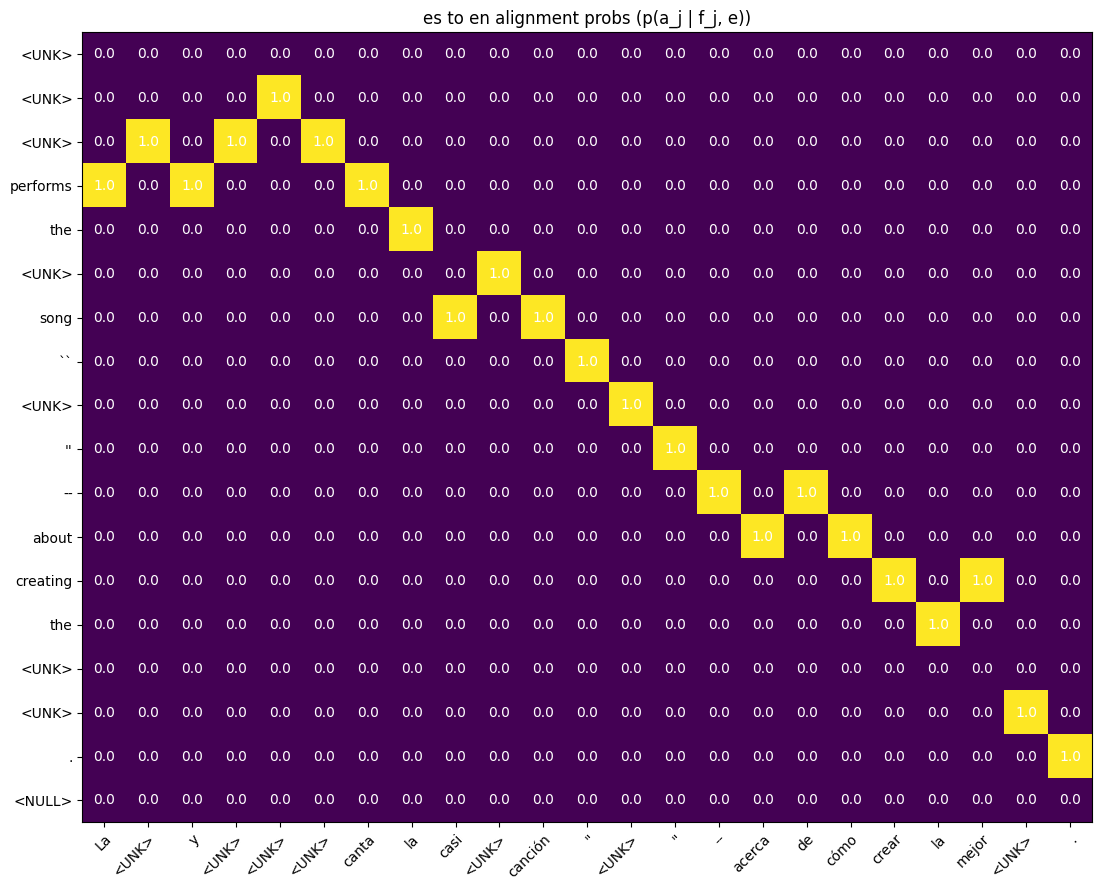

In [135]:
# look at alignments gotten for particular sentences:
for i, (e, s) in enumerate(data):
    if 10 < len(e) < 20 and ":" not in e and i not in [1, 2386, 2724, 3177] :
        print(i, e, s)# need to make a grid for the sentences and put the p(a_j = i | f_j, e)
        print(english_tokens_filtered[i])
        print(spanish_tokens_filtered[i])
        # english on the rows and columns are the spanish.
        visualize_sentence_alignments(get_alignment_matrix_model_HMM(model_p, e, s), e,s)
        break

In [ ]:
# jit optimized not worth. The E step still takes 7 minutes.
# from numba import jit
# import math
# @jit
# def allinone_numba_model(data):
#     model_p_word = dict()
#     model_p_transition = dict()
    
#     for e, s in data:
#         l, m = len(e), len(s)
#         for i, e_i in enumerate(e):
#             model_p_transition[(i,l)] = 0.
#             for j, s_j in enumerate(s):
#                 model_p_word[(s_j, e_i)] = 0.
#     # just normalize over the number of options available for each parameter:
#     num_s = len(set([p[0] for p in model_p_word.keys() if len(p) == 2 and isinstance(p[0], str)])) 
#     for key in model_p_transition.keys():
#         model_p_transition[key] = 1 / float(key[1])
#     for key in model_p_word.keys():
#         model_p_word[key] = 1 / float(num_s)
    
#     def forward_alg(en, es, model_word, model_transition):
#         # this needs the model to have a prior for the probability of starting at each position.
#         # for this assumption, I call z_0 =  -1, and then use the Q model to give me the probability of transitioning form -1 to 0, 1, 2, ... l. 
#         # This biases the probability to start near the beginning if the Q model doesn't do a lot of skipping around.
#         # I need to deal in log probs else it is unstable. ->> nevermind, I don't think I can really, because I need to exp the values to get true probabilities for the recursive case any way. The sum from the latents prevents moving the log in, and covering the prob of x, z.
#         m, l = len(es), len(en)
#         prob_x_leq_k_and_z_k = [[0.] * m for _ in range(l)]
#         for i in range(l):
#             prob_x_leq_k_and_z_k[i][0] = model_transition[(min(int(abs(-1 - i)), l-1), l)] * model_word[(es[0], en[0])] # need to account for edge case where you try to get an impossible distance.
#         for j in range(1, m):
#             for i in range(l):
#                 prob_x_leq_k_and_z_k[i][j] = model_word[(es[j], en[i])] * sum([model_transition[(int(abs(k-i)), l)] * prob_x_leq_k_and_z_k[k][j-1] for k in range(l)])
#         # the forward's recurrence tries to capture p(z_j = i, x_{1:j}) = p(x_j | z_j = i) * sum_k(p(z_j = i | z_{j-1} = k) * p(z_{j-1} = k, x_{1:j-1}))

#         return prob_x_leq_k_and_z_k
#     def backward_alg(en, es, model_word, model_transition):
#         # here we want to get p(x_{j+1:l} | z_j = i) to be able to combine with fwd to get the probability of a sequence given some choice of the latent.
#         # p(x_{j+1:l} | z_j = i) = sum_k^l( p(x_{j+1} | z_{j+1} = k) * p(z_{j+1} = k | z_j = i) p(x_{j+2:l} | z_{j+1} = k))
#         m, l = len(es), len(en)
#         prob_x_gt_k_given_z_k = [[0.] * m for _ in range(l)]
#         # init the beginning, but to what, just see how it is used in the recurrence:
#         # p(x_{l:l} | z_{l-1} = i) = sum_k^l( p(z_l = k | z_{l-1} = i) * p(x_l | z_l = k) ) # hence if we want our recurrence to be defined here, just set the probabilities of the l'th column to be all 1s.
#         for i in range(l):
#             prob_x_gt_k_given_z_k[i][-1] = 1
#         for j in list(range(m-2, -1, -1)):
#             for i in range(l):
#                 prob_x_gt_k_given_z_k[i][j] = sum([model_transition[(int(abs(i - k)), l)] * model_word[(es[j], en[k])] * prob_x_gt_k_given_z_k[k][j+1] for k in range(l)])
        
#         return prob_x_gt_k_given_z_k
#     def get_likelihood_model_HMM(model_word, model_transition, dataloader):
#         likelihood = 0
#         # we want to get log(p(f | e))
#         for en, es in dataloader:
#             # getting the probability of the data with the model involves: for each f, e sentence
#             # p(f | e) = p(f | e), which is easy to get from the forward process, as we use our markov model. 
#             # Otherwise we might want to do the sum over the sum of all possible alignments.
#             prob_x_leq_j_and_z_j = forward_alg(en, es, model_word, model_transition)
#             prob_x_given_e = sum([prob_x_leq_j_and_z_j[i][-1] for i in range(len(en))])
#             if prob_x_given_e != 0.:
#                 likelihood += math.log(prob_x_given_e)
#             else:
#                 pass
#                 # print("zero probability translation event:", len(en), len(es), en, es)
#         return likelihood
#     def perform_E_step_model_HMM(model_word, model_transition, dataloader):
#         # to get the E step, you have to essentially find the Q(a_j | a_{j-1}, f_j, e), which comes out of model. for this you apply bayes, and use your existing model?
#         # Q(a_j | a_{j-1}, f_j, e) = Q(a_j | a_{j-1}, e) * p(f_j | e_{a_j}) / sum_k^l(Q(a_j = k | a_{j-1}, e) * p(f_j | e_k))
#         longest_english_sentence = max([len(en) for en, es in dataloader])

#         counts_word = dict()
#         for k in model_word.keys():
#             counts_word[k] = 0.
#         counts_transition = dict()
#         for i in range(longest_english_sentence):
#             counts_transition[(i,)] = 0.
        

#         for en, es in dataloader:
#             m, l = len(es), len(en)
#             prob_f_leq_j_and_a_j_given_e = forward_alg(en, es, model_word, model_transition) # 2 * m * l * l operation
#             prob_f_gt_j_given_a_j_given_e = backward_alg(en, es, model_word, model_transition)
#             prob_f_and_a_j_given_e = [[f_i * b_i for f_i,b_i in zip(f, b)] for f,b in zip(prob_f_leq_j_and_a_j_given_e, prob_f_gt_j_given_a_j_given_e)]
#             q_f_given_e = sum([prob_f_and_a_j_given_e[k][-1] for k in range(l)]) 
#             if q_f_given_e == 0.:
#                 continue
#             for j, s in enumerate(es):
#                 for i, e in enumerate(en):
#                     # update the counts of the f_j, e_i pairs based on the Q(a_j| f, e)
#                     q_a_j_given_f_and_e = prob_f_and_a_j_given_e[i][j] / q_f_given_e
#                     counts_word[(s,e)] += q_a_j_given_f_and_e
#                     for prior_i in range(l):
#                         # update the counts of the transition probabilities for relative locations on the markov chain with
#                         # Q(a_j, a_{j-1} | f, e), and compute this with bayes on Q(a_j, a_{j-1}, f | e) / Q(f | e)
#                         # Q(a_j, a_{j-1}, f | e) = p(f_{1:j-1},a_{j-1}|e) * Q(a_j|a_{j-1},e) * p(f_j|a_j,e) * p(f_{j+1:m}|a_j,e)
#                         q_a_j_and_a_jm1_and_f_given_e = prob_f_leq_j_and_a_j_given_e[prior_i][j-1] * model_transition[(int(abs(i - prior_i)), l)] * model_word[(s,e)] * prob_f_gt_j_given_a_j_given_e[i][j]
#                         q_a_j_and_a_jm1_given_f_and_e = q_a_j_and_a_jm1_and_f_given_e / q_f_given_e
#                         counts_transition[(int(abs(i - prior_i)),)] += q_a_j_and_a_jm1_given_f_and_e
#         return counts_word, counts_transition

#     # def perform_M_step_model_HMM(counts_word, counts_transition):
#     #     # normalize the counts
#     #     # we have two counts, counts for relative locations, and counts for the alignment of f_j to e_i, getting the latter is easy:
#     #     new_model_word = dict()
#     #     new_model_transition = dict()
#     #     total_e_i_counts = dict()
#     #     for key in counts.keys():
#     #         total_e_i_counts[key] = 0.
#     #     lengths = set([key[1] for key in counts_transition.keys()])
#     #     for key, count in counts_word.items():
#     #         if isinstance(key[0], str):
#     #             total_e_i_counts[key[1]] += count
#     #     for length in lengths:
#     #         normalizing_prob_i_given_prior_i = sum(counts[(k,)] for k in range(length))
#     #         for i in range(length):
#     #             new_model_transition[(i, length)] = counts[(i,)] / normalizing_prob_i_given_prior_i
#     #     for key, count in counts_word.items():
#     #         new_model_word[key] = count/ total_e_i_counts[key[1]]
#     #     return new_model_word, new_model_transition
#     counts_word, counts_transition = perform_E_step_model_HMM(model_p_word, model_p_transition, data)
#     return counts_word, counts_transition
#     # return perform_M_step_model_HMM(counts_word, counts_transition)

# data2 = [(['<UNK>','<UNK>',"'s",'photography','challenges','how','we','think','about','<UNK>','color','and','<UNK>','identity','.','In','this','personal','talk',',','hear','about','the','inspiration','behind','her','<UNK>','project',',','<UNK>',',','and','her','<UNK>','to','<UNK>','humanity',"'s",'true','<UNK>','rather','than','the','<UNK>','<UNK>',',','<UNK>',',','black','and','<UNK>','<UNK>','with','race','.','<NULL>'], ['La','fotografía','de','<UNK>','<UNK>','<UNK>','nuestra','forma','de','pensar','sobre','el','color','de','la','<UNK>','y','la','identidad','<UNK>','.','<UNK>','esta','charla','personal','acerca','de','la','inspiración','detrás','de','su','proyecto','de','<UNK>',',','<UNK>',',','y','su','búsqueda','para','<UNK>','el','verdadero','color','de','la','humanidad','en','lugar','del','<UNK>','color','de','<UNK>','<UNK>',',','<UNK>',',','<UNK>','<UNK>','<UNK>','<UNK>','con','la','<UNK>','.']),
#  (['<UNK>','<UNK>',':','The','beauty','of','human','<UNK>','in','every','color','<NULL>'], ['<UNK>','<UNK>',':','La','belleza','del','color','de','la','<UNK>','humana']),
#  (['<UNK>','are','so','well','<UNK>','to','the','<UNK>','that','it',"'s",'hard','to','imagine','them','living','anywhere','else','.','But','what','if','we','have','them','<UNK>','all','wrong','?','What','if','those','big','<UNK>',',','<UNK>','and','eyes','were','<UNK>','for','a','different','climate','and','a','different','time','?','In','this','talk',',','join','<UNK>',"'s",'<UNK>','<UNK>','as','he','tells','the','surprising','story','of','how','a','very','tiny',',','very','strange','<UNK>','<UNK>','the','way','he','<UNK>','<UNK>',',','and','the','world','.','This','talk','comes','from','the','<UNK>','<UNK>','special','TED','<UNK>',':','<UNK>','&','<UNK>',',','which','<UNK>','<UNK>','<UNK>','at','10','<UNK>','.','<UNK>','.','<NULL>'], ['Los','<UNK>','están','tan','bien','<UNK>','al','<UNK>','que','es','difícil','<UNK>','en','otro','lugar','.','Pero','¿','y','si','los','hemos','<UNK>','mal','?','¿','Y','si','<UNK>','esas','grandes','<UNK>',',','esas','<UNK>','<UNK>',' ','y','esos','ojos','enormes','para','un','<UNK>','y','una','era','diferente','?','En','esta','charla',',','<UNK>','a','<UNK>','<UNK>','de','<UNK>','<UNK>','cuenta','la','sorprendente','historia','de','cómo','un','<UNK>','y','<UNK>','<UNK>','<UNK>','su','forma','de','ver','los','<UNK>','y','el','mundo','.']),
#  (['<UNK>','<UNK>',':','You','have','no','idea','where','<UNK>','really','come','from','<NULL>'], ['<UNK>','<UNK>',':','No','<UNK>','idea','de','dónde','<UNK>','los','<UNK>']),
#  (['What','if','technology','could','connect','us','more','deeply','with','our','<UNK>','instead','of','<UNK>','us','from','the','real','world','?','With','the','<UNK>','2',',','an','augmented','reality','<UNK>','that','makes','it','possible','for','users','to','see',',','<UNK>','and','move','<UNK>','just','like','physical','objects',',','<UNK>','<UNK>','hopes','to','<UNK>','our','<UNK>','through','a','more','natural','machine','.','<UNK>','<UNK>','as','he','takes','the','TED','stage','to','<UNK>','the','<UNK>','<UNK>','2','for','the','first','time','.','(','<UNK>','<UNK>','&','A','with','TED','<UNK>','Chris','Anderson',')','<NULL>'], ['¿','Qué','<UNK>','si','la','tecnología','<UNK>','<UNK>','mejor','al','<UNK>','que','nos','<UNK>','en','lugar','de','<UNK>','del','mundo','real','?','Con','<UNK>','2',',','un','<UNK>','de','realidad','virtual','que','nos','permite','ver',',','tomar','y','<UNK>','<UNK>','como','si','<UNK>','objetos','reales',',','<UNK>','<UNK>','<UNK>','<UNK>','nuestros','<UNK>','en','lugar','de','<UNK>','.','<UNK>','a','<UNK>','que','<UNK>','al','escenario','TED','para','mostrar','por','primera','vez','la','realidad','virtual','a','través','de','<UNK>','2','(','durante','una','sesión','de','preguntas','y','respuestas','con','Chris','Anderson',',','curador','de','TED',')','.']),
#  (['<UNK>','<UNK>',':','A','glimpse','of','the','future','through','an','augmented','reality','<UNK>','<NULL>'], ['<UNK>','<UNK>',':','<UNK>','hacia','el','futuro','a','través','de','un','<UNK>','de','realidad','virtual']),
#  (['We','do',"n't",'have','to','live','in','a','world','where','<UNK>','percent','of','<UNK>','get','away','with','it',',','says','TED','Fellow','<UNK>','<UNK>','.','With','<UNK>',',','a','new','<UNK>','for','college','students','to','<UNK>','<UNK>','sexual','<UNK>',',','<UNK>','is','helping','<UNK>','get','the','<UNK>','and','justice','they','<UNK>','while','<UNK>','their','privacy','<UNK>','.','``','We','can','create','a','world','where','there',"'s",'a','real','<UNK>','to','<UNK>','the','rights','of','another','human','being',',',"''",'she','says','.','<NULL>'], ['<UNK>','<UNK>',',','<UNK>','TED',',','afirma','que','no','debemos','vivir','en','un','mundo','en','el','que','no','se','<UNK>','al','<UNK>','%','de','los','<UNK>','.','Con','<UNK>',',','una','nueva','<UNK>','<UNK>','a','estudiantes','<UNK>','para','<UNK>','de','<UNK>','<UNK>','de','forma','<UNK>',',','<UNK>','está','<UNK>','a','las','<UNK>','a','<UNK>','la','ayuda','y','la','justicia','que','se','<UNK>',',','y','al','mismo','tiempo','está','<UNK>','su','privacidad','.','"','Podemos','crear','un','mundo','en','el','que','<UNK>','<UNK>','<UNK>','<UNK>','para','la','violencia','en','contra','los','derechos','de','otros','seres','humanos','"','.']),
#  (['<UNK>','<UNK>',':','The','<UNK>','system','that','sexual','<UNK>','<UNK>','want','<NULL>'], ['<UNK>','<UNK>',':','El','sistema','de','<UNK>','que','<UNK>','las','<UNK>','de','<UNK>','<UNK>']),
#  (['Tim','<UNK>','<UNK>','that','<UNK>','does',"n't",'make','sense',',','but','he',"'s",'never','been','able','to','<UNK>','his','<UNK>','of','<UNK>','until','the','last','<UNK>','to','get','things','done','.','In','this','hilarious','and','<UNK>','talk',',','<UNK>','takes','us','on','a','journey','through','YouTube','<UNK>',',','<UNK>','<UNK>','<UNK>','and','<UNK>','of','<UNK>','out','the','<UNK>','--','and','<UNK>','us','to','think','<UNK>','about','what','we',"'re",'really','<UNK>','on',',','before','we','run','out','of','time','.','<NULL>'], ['Tim','<UNK>','sabe','que','la','<UNK>','no','tiene','sentido',',','pero','que','nunca','ha','sido','capaz','de','<UNK>','de','su','<UNK>','de','<UNK>','hasta','el','último','<UNK>','para','hacer','las','cosas','.','En','esta','charla','divertida','y','<UNK>',',','<UNK>','nos','lleva','en','un','viaje','a','través','de','<UNK>','de','YouTube',',','<UNK>','de','<UNK>','y','<UNK>','al','mundo','a','través','de','una','pantalla','...','y','nos','invita','a','<UNK>','qué','estamos','<UNK>',',','antes','de','que','se','nos','<UNK>','el','tiempo','.']),
#  (['Tim','<UNK>',':','<UNK>','the','mind','of','a','<UNK>','<UNK>','<NULL>'], ['Tim', '<UNK>', ':', 'En', 'la', 'mente', 'de', 'un', '<UNK>', '<UNK>'])]

# allinone_numba_model(data);